In [1]:
dataset <- "ARPAL"
state <- "Liguria"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
scia_meta <- query_checkpoint_meta("SCIA", "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 1000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!state %in% c("Piemonte", "Emilia-Romagna", "Toscana"), !(network %in% c("Sinottica", "Mareografica")))

metas <- bind_rows(ds_meta, scia_meta) |> mutate(key = row_number()) #|> mutate(dataset = if_else(dataset == "SCIA", 2L, 1L))
metas <- copy_to(conns$data, metas, "metas_tmp", overwrite = TRUE)
matches <- close_matches(metas, 10000, conns$stations)

data <- query_checkpoint_data(c(dataset, "SCIA"), "qc1", conns$data) |>
    filter(valid) |>
    left_join(metas |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key"))

smatches <- series_matches(data, matches, metas)


In [4]:
analysis1 <- series_matches_analysis(smatches, data, metas)


In [5]:
write_xlsx_analysis(analysis1, "notebooks/integrazioni_regionali/liguria/analysis.xlsx", starts_with("user_code"), starts_with("sensor_id"))


In [6]:
analysis1 |>
    filter(str_detect(user_code_y, user_code_x)) |>
    write_xlsx_analysis("notebooks/integrazioni_regionali/liguria/same_code_analysis.xlsx", starts_with("user_code"), starts_with("sensor_id"))


In [7]:
source("notebooks/integrazioni_regionali/liguria/procedures/match_taggers.R")
source("src/merging/tagging.R")
tagged_analysis <- tag_same_series(analysis1) |>
    tag_mergeable() |>
    default_logic(require_all = TRUE)
tagged_analysis |> write_xlsx_analysis("notebooks/integrazioni_regionali/liguria/same_series_analysis.xlsx", starts_with("user_code"), starts_with("sensor_id"), starts_with("tag_"))


In [8]:
source("src/merging/combining.R")
gs <- series_groups(tagged_analysis, metas, tag_same_series, group_by_component, FALSE)


In [9]:
source("src/merging/display.R")
m <- collect(metas)
# leaflet_groups(gs$table |> left_join(m |> select(key, sensor_key, dataset), by = "key"), m, gkey) |> render_map()


In [10]:
gs$table |>
    left_join(m |> select(key, sensor_key, dataset, name), by = "key") |>
    filter(str_detect(name |> str_to_lower(), "calice"))


key,gkey,sensor_key,dataset,name
<int>,<int>,<int>,<chr>,<chr>
20,15,20,ARPAL,CALICE AL C. - MOLUNGHI
21,15,21,ARPAL,CALICE AL CORNOVIGLIO
225,15,688,SCIA,Calice al Cornoviglio
226,15,689,SCIA,Calice al Cornoviglio
22,16,22,ARPAL,CALICE LIGURE
223,16,686,SCIA,Calice Ligure
224,16,687,SCIA,Calice Ligure
23,16,23,ARPAL,CALICE LIGURE - CA ROSSE


In [11]:
gs$table |>
    distinct(gkey) |>
    nrow()


[1] 209

In [12]:
gs$table |>
    left_join(m |> select(key, sensor_key, dataset, name), by = "key") |>
    filter(sensor_key %in% c(185L, 186L))


key,gkey,sensor_key,dataset,name
<int>,<int>,<int>,<chr>,<chr>
183,135,185,ARPAL,VERZI LOANO
184,157,186,ARPAL,VERZI LOANO


In [13]:
gs$table |>
    left_join(m |> select(key, sensor_key, dataset, name), by = "key") |>
    group_by(gkey) |>
    filter(str_detect(name |> str_to_lower(), "calice al c"))


key,gkey,sensor_key,dataset,name
<int>,<int>,<int>,<chr>,<chr>
20,15,20,ARPAL,CALICE AL C. - MOLUNGHI
21,15,21,ARPAL,CALICE AL CORNOVIGLIO
225,15,688,SCIA,Calice al Cornoviglio
226,15,689,SCIA,Calice al Cornoviglio


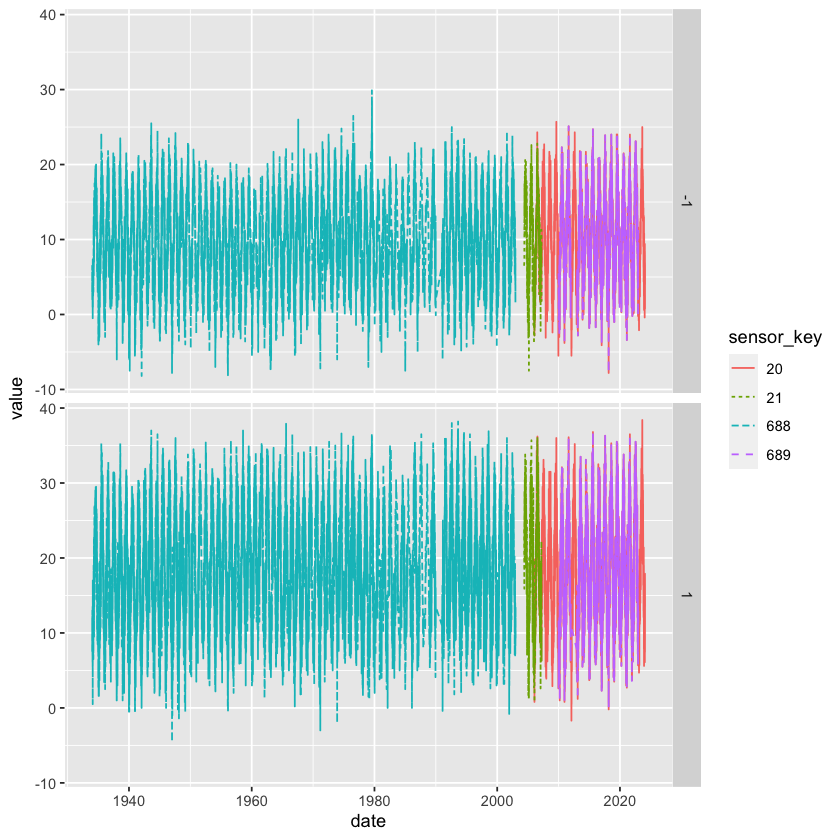

In [14]:
source("src/database/plot.R")
ids <- tibble(sensor_key = c(185L, 186L), dataset = "ARPAL")
ids <- gs$table |>
    left_join(m |> select(key, sensor_key, dataset, name), by = "key") |>
    filter(str_detect(name |> str_to_lower(), "calice al c")) |>
    select(sensor_key, dataset)
plot_stations(ids, data, FALSE)


In [15]:
gs$table |>
    left_join(m |> select(key, sensor_key, dataset, name, station_key, series_key), by = "key") |>
    filter(dataset == "ARPAL") |>
    group_by(gkey) |>
    filter(n() > 1) |>
    arrange(gkey)


key,gkey,sensor_key,dataset,name,station_key,series_key
<int>,<int>,<int>,<chr>,<chr>,<int>,<int>
1,1,1,ARPAL,AIROLE,2,1
2,1,2,ARPAL,AIROLE,1,1
20,15,20,ARPAL,CALICE AL C. - MOLUNGHI,20,19
21,15,21,ARPAL,CALICE AL CORNOVIGLIO,21,20
22,16,22,ARPAL,CALICE LIGURE,23,21
23,16,23,ARPAL,CALICE LIGURE - CA ROSSE,22,22
24,17,24,ARPAL,CAMOGLI,24,23
25,17,25,ARPAL,CAMOGLI,25,23
28,19,28,ARPAL,CARPE,29,26


In [16]:
source("src/merging/combining.R")
merged_series <- merge_series_groups.2(gs$table, m, data, c("ARPAL", "SCIA"), dataset, desc(sensor_last))


In [17]:
sources <- merged_series |>
    distinct(gkey, from_dataset, from_key) |>
    group_by(gkey) |>
    summarise(source = if_else(n() > 1, "merged", first(from_dataset)))
merged_series <- merged_series |> left_join(sources, by = "gkey")


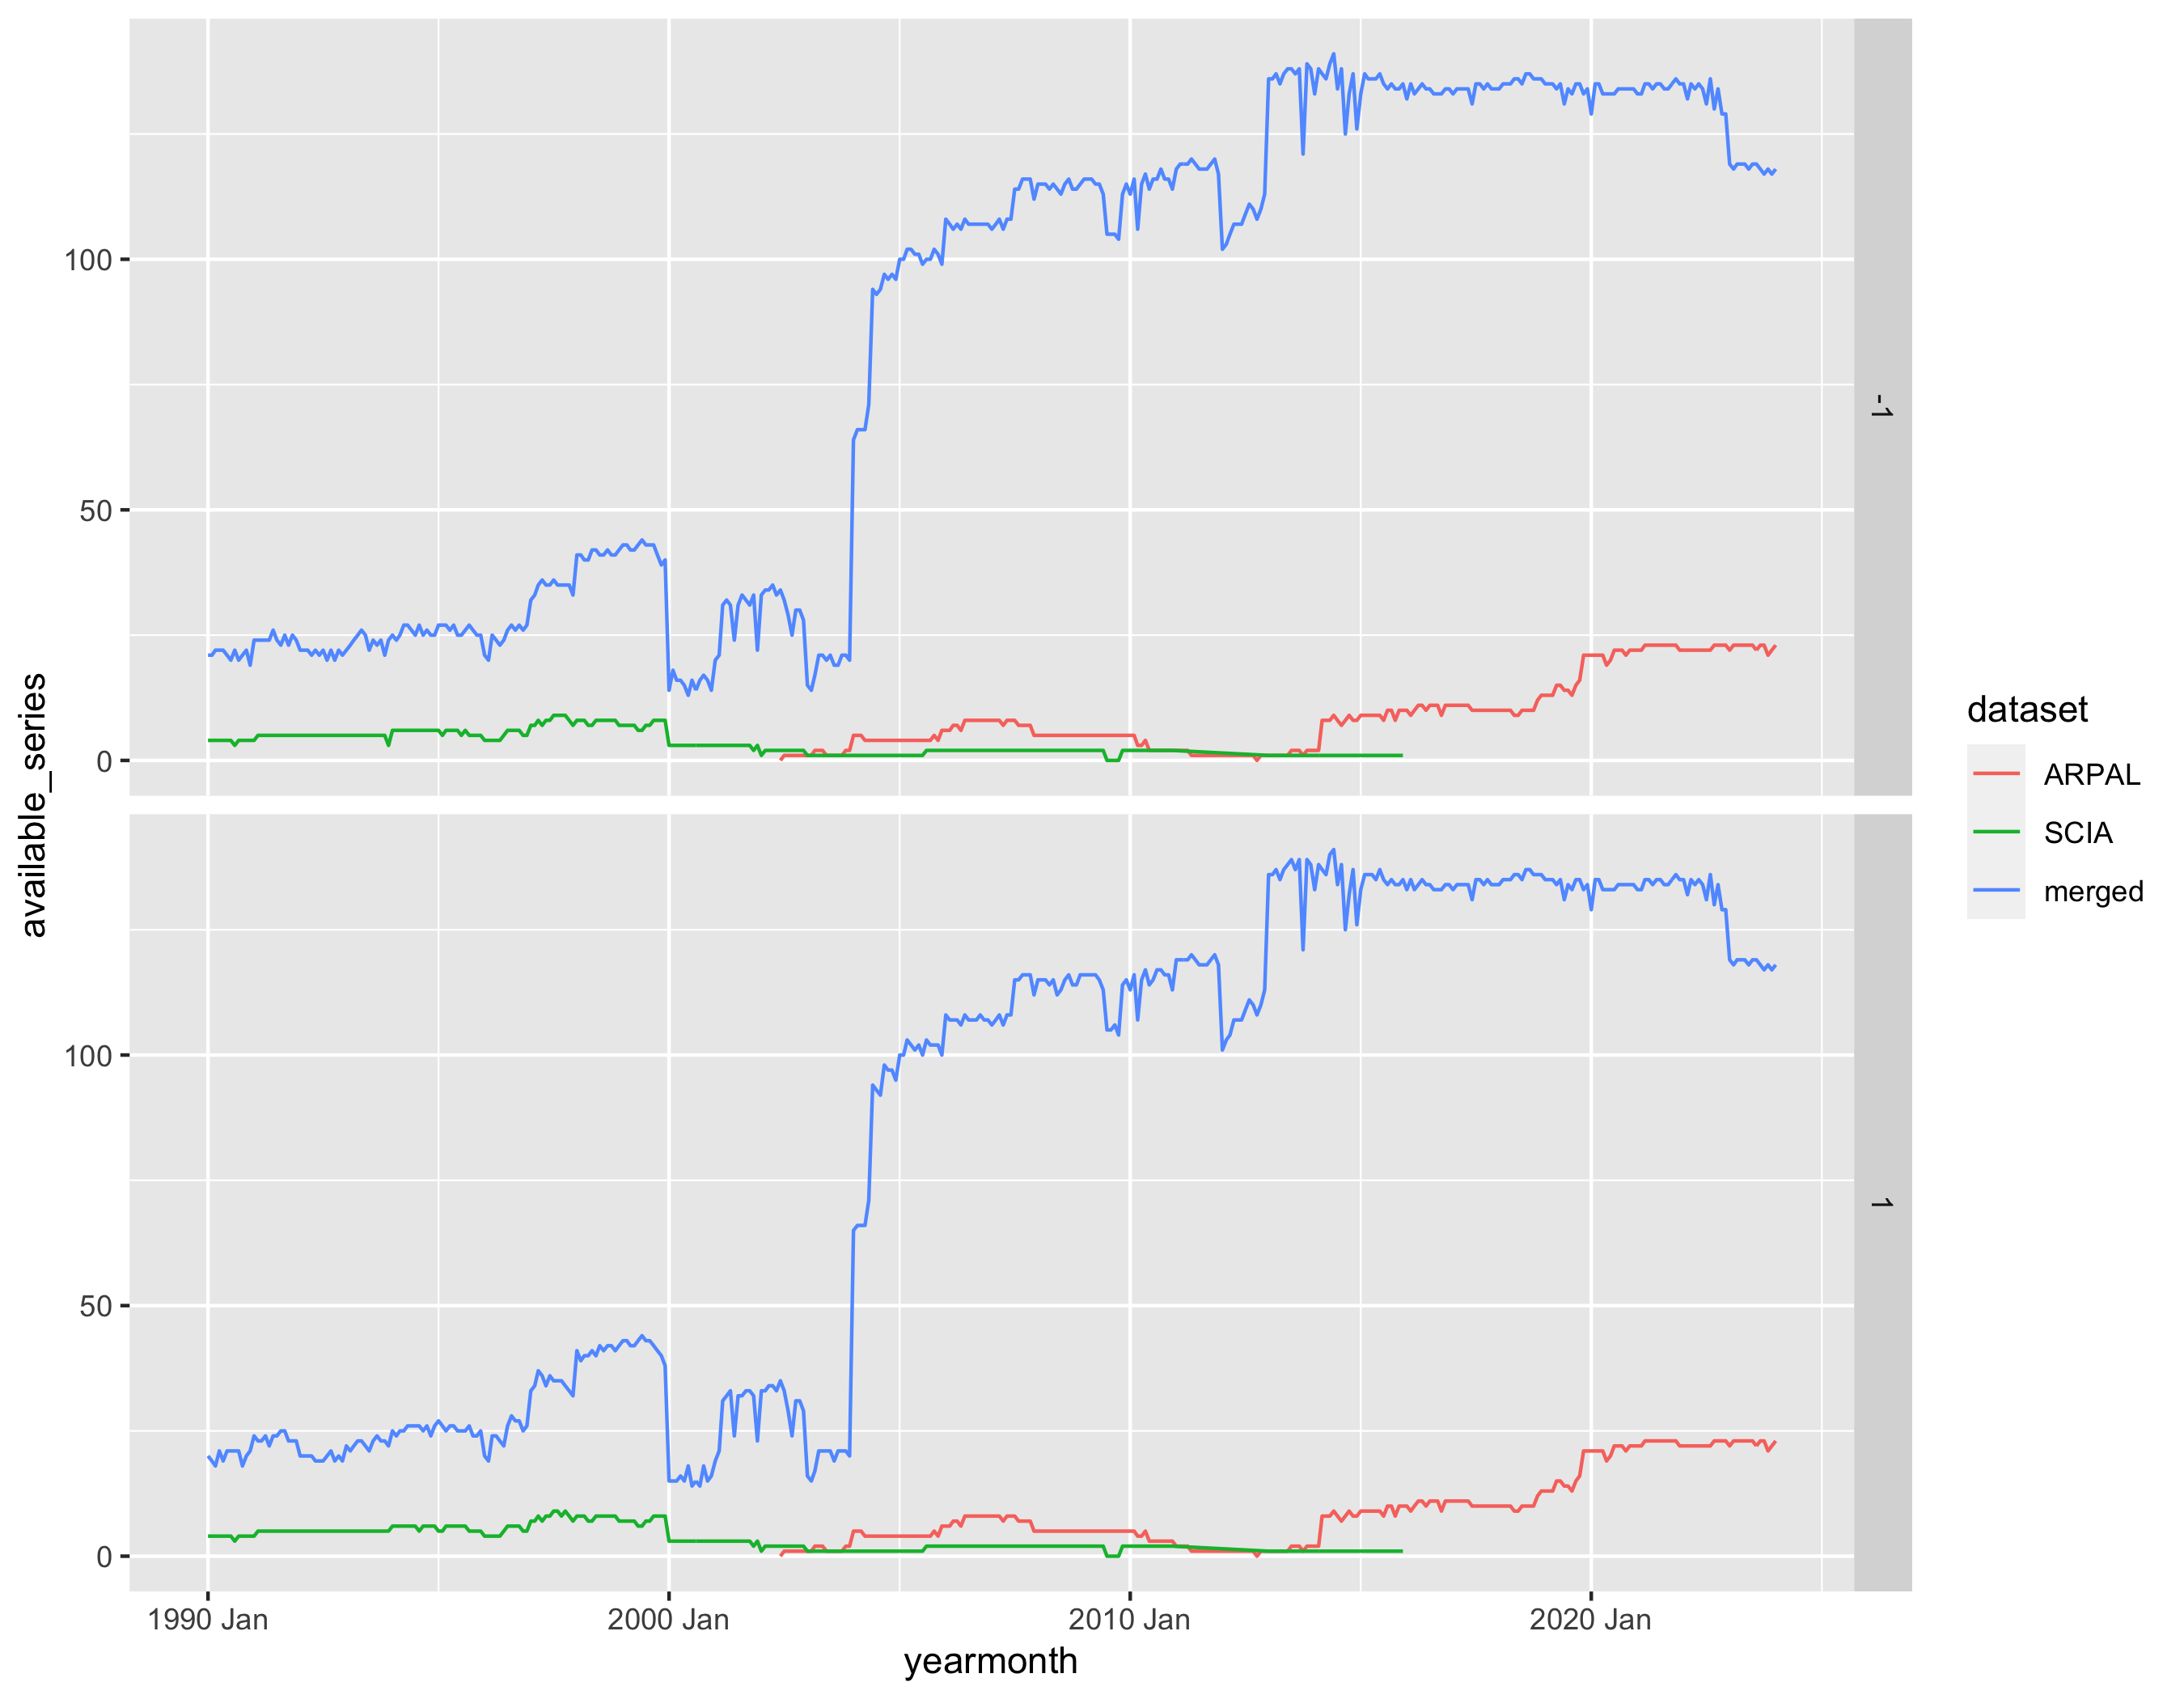

In [18]:
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
pp <- merged_series |>
    filter(year(date) >= 1990L) |>
    rename(sensor_key = gkey, dataset = source) |>
    group_by(dataset) |>
    ymonthly_availabilities()
pp$plot + facet_grid(variable ~ .)


### Showing non-merged series

In [19]:
merged_series |>
    filter(source != "merged") |>
    distinct(from_dataset, from_sensor) |>
    left_join(metas |> select(dataset, name, sensor_key, lon, lat), by = c("from_dataset" = "dataset", "from_sensor" = "sensor_key")) |>
    collect() |>
    arrange(name) |>
    write.xlsx("notebooks/integrazioni_regionali/liguria/non_merged.xlsx", asTable = TRUE)


In [20]:
source("src/merging/display.R")
leaflet_groups(
    gs$table |>
        left_join(m |> select(key, sensor_key, dataset, name), by = "key") |>
        filter(str_to_lower(name) == "mattarana") |>
        select(-name),
    m,
    gkey
) |> render_map()



Listening on http://127.0.0.1:3117



In [ ]:
gs$table |>
        left_join(m |> select(key, sensor_key, dataset, name), by = "key")

key,gkey,sensor_key,dataset,name
<int>,<int>,<int>,<chr>,<chr>
1,1,1,ARPAL,AIROLE
2,1,2,ARPAL,AIROLE
188,1,105,SCIA,Airole
189,1,106,SCIA,Airole
3,2,3,ARPAL,ALASSIO
190,2,108,SCIA,Alassio
191,2,109,SCIA,Alassio
4,3,4,ARPAL,ALBENGA - ISOLABELLA
193,3,113,SCIA,Albenga - Isolabella
